# Pneumonia detection

In [ ]:
import os
import math
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import datetime
from PIL import Image
from random import randint

layers = tf.keras.layers
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
BatchNormalization = tf.keras.layers.BatchNormalization
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
Flatten = tf.keras.layers.Flatten
TensorBoard = tf.keras.callbacks.TensorBoard
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

Using TensorFlow backend.


## Prepare data for input

In [ ]:
# Creating paths for the directories containing the input images
directory = "data\\chest_xray"
train_directory = "data\\chest_xray\\train"
test_directory = "data\\chest_xray\\test"
val_directory = "data\\chest_xray\\val"

train_normal_dir = os.path.join(train_directory, "NORMAL")
train_pneumonia_dir = os.path.join(train_directory, "PNEUMONIA")
test_normal_dir = os.path.join(test_directory, "NORMAL")
test_pneumonia_dir = os.path.join(test_directory, "PNEUMONIA")
val_normal_dir = os.path.join(val_directory, "NORMAL")
val_pneumonia_dir = os.path.join(val_directory, "PNEUMONIA")

# Assigning the number of examples to variables
number_normal_train = len(os.listdir(train_normal_dir))
number_normal_test = len(os.listdir(test_normal_dir))
number_normal_val = len(os.listdir(val_normal_dir))
number_pneumonia_train = len(os.listdir(train_pneumonia_dir))
number_pneumonia_test = len(os.listdir(test_pneumonia_dir))
number_pneumonia_val = len(os.listdir(val_pneumonia_dir))

total_train = number_normal_train + number_pneumonia_train
total_test = number_normal_test + number_pneumonia_test
total_val = number_normal_val + number_pneumonia_val

# Specifying the size of the batches and the dimensions of the input data
batch_size = 128
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Creating generators of input data
train_datagen = ImageDataGenerator(zoom_range = 0.2,
                                   rotation_range = 10,
                                   horizontal_flip = False,
                                   rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory(train_directory,
                                                    batch_size = 5217,
                                                    class_mode = "categorical",
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH))

val_datagen = ImageDataGenerator(zoom_range = 0.2,
                                 rotation_range = 10,
                                 horizontal_flip = False,
                                 rescale = 1.0/255)
 
val_generator = val_datagen.flow_from_directory(test_directory,
                                                batch_size = 624,
                                                class_mode = "categorical",
                                                target_size = (IMG_HEIGHT, IMG_WIDTH))

Found 5217 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Data exploration

In [ ]:
# See how the classes are encoded
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Assigning examples coming from the generator to variables that will serve as input
x_train, y_train = next(train_generator)
x_test, y_test = next(val_generator)

# Verify whether x_train and y_train have the same length by printing the length
print("Length x_train:", len(x_train))
print("Length y_train:", len(y_train))

Length x_train: 5217
Length y_train: 5217


In [ ]:
def find_label(encoding):
    """Returns the correct class to which an instance belongs (i.e. "Normal" or
    "Pneumonia") based on the Numpy-array encoding which has been assigned to it."""
    if encoding[0] == 1:
        return "Normal"
    if encoding[1] == 1:
        return "Pneumonia"

In [ ]:
# Plot several instances to visualise the data that we are dealing with
plt.figure(figsize = (14, 14))
for index in range(0, 16):
    ax = plt.subplot(4, 4, index + 1)
    ax.set_title(find_label(y_train[index]))
    plt.imshow(x_train[index])

In [ ]:
# Printing how many of normal/pneumonia instances are among the different datasets
print("Normal cases in the train dataset:", number_normal_train)
print("Normal cases in the test dataset:", number_normal_test)
print("Normal cases in the validation dataset:", number_normal_val)
print("Pneumonia cases in the train dataset:", number_pneumonia_train)
print("Pneumonia cases in the test dataset:", number_pneumonia_test)
print("Pneumonia cases in the validation dataset:", number_pneumonia_val)

Normal cases in the train dataset: 1343
Normal cases in the test dataset: 234
Normal cases in the validation dataset: 9
Pneumonia cases in the train dataset: 3876
Pneumonia cases in the test dataset: 390
Pneumonia cases in the validation dataset: 9


## Modelling

In [ ]:
def create_model():
    # Instantiating a Sequential model from Keras
    classifier = tf.keras.models.Sequential()

    # Adding layers to the "Classifier" model
    classifier.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape = (150, 150, 3), activation = "relu"))
    classifier.add(tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"))
    classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"))
    classifier.add(tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"))
    classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(tf.keras.layers.Conv2D(16, (5, 5), activation = "relu"))
    classifier.add(tf.keras.layers.Conv2D(16, (5, 5), activation = "relu"))
    classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(tf.keras.layers.Flatten())
    classifier.add(tf.keras.layers.Dropout(0.3))
    classifier.add(tf.keras.layers.Dense(units = 1024, activation = "relu"))
    classifier.add(tf.keras.layers.Dense(units = 2, activation = "softmax"))

    # Selecting an appropriate optimizer (result from grid search conducted during experimentation)
    rmsprop = tf.keras.optimizers.RMSprop(lr = 0.0001, rho = 0.9)

    # Compile the model by passing the loss function, optimizer and metrics
    classifier.compile(optimizer = rmsprop,
                       loss = "binary_crossentropy",
                       metrics = ["accuracy"])
    
    return classifier

In [ ]:
classifier = create_model()

# Summarise the different layers and number of parameters in the model
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 16)        1

## Training the model

In [ ]:
# Provide path to which the best epoch will be saved during training
checkpoint_path = "DL_Project_BestModelWeights.hdf5"

# Creating a checkpoint for saving the best epoch
checkpoint = ModelCheckpoint(checkpoint_path, monitor = "val_accuracy", verbose = 1,
                             save_best_only = True, mode = "auto")

# Fitting the model and train the model by providing train and test data
history = classifier.fit(x = x_train,
                         y = y_train,
                         validation_data = (x_test, y_test),
                         epochs = 50,
                         verbose = 1,
                         callbacks = [checkpoint])

Train on 5217 samples, validate on 624 samples
Epoch 1/50
5216/5217 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.7872
Epoch 00001: val_accuracy improved from -inf to 0.80128, saving model to JADS_DL_Project_BestModelWeights.hdf5
5217/5217 [==============================] - 37s 7ms/sample - loss: 0.4605 - accuracy: 0.7872 - val_loss: 0.4284 - val_accuracy: 0.8013
Epoch 2/50
5216/5217 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.8622
Epoch 00002: val_accuracy did not improve from 0.80128
5217/5217 [==============================] - 32s 6ms/sample - loss: 0.3171 - accuracy: 0.8620 - val_loss: 0.4835 - val_accuracy: 0.7788
Epoch 3/50
5216/5217 [============================>.] - ETA: 0s - loss: 0.2801 - accuracy: 0.8808
Epoch 00003: val_accuracy did not improve from 0.80128
5217/5217 [==============================] - 32s 6ms/sample - loss: 0.2800 - accuracy: 0.8808 - val_loss: 0.5216 - val_accuracy: 0.8013
Epoch 4/50
5216/5217 [========

## Evaluation

Text(0.5, 1.0, 'Training and validation loss')

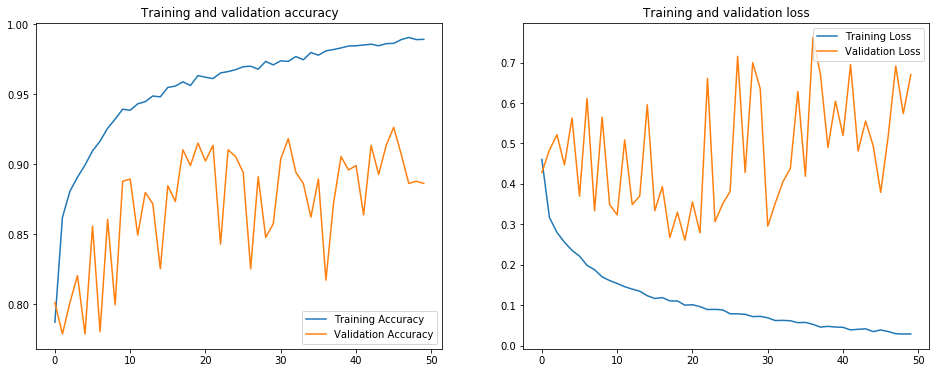

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(history.history["loss"]))

plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "Training Loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and validation loss")

In [ ]:
# Restore the weights from the best epoch to use for further evaluation
model = create_model()
model.load_weights(checkpoint_path)
model.evaluate(x_test, y_test, verbose = 0)

[0.37905680445524365, 0.92628205]

In [ ]:
def convert_encoding(encoding):
    """Converts the one-hot encoding used when training to an integer value, where
    0 represents a Normal case and 1 represents a Pneumonia case."""
    if encoding[0] >= encoding[1]:
        return 0
    if encoding[0] < encoding[1]:
        return 1

# Make predictions for the test set using the best model that has been retrieved
true_values = y_test
predicted_values = model.predict(x_test)

# Create an array containing the true labels converted to integers instead of one-hots
true_labels = []
for element in true_values:
    true_labels.append(convert_encoding(element))

# Create an array containing the predicted labels converted to integers instead of one-hots
predicted_labels = []
for element in predicted_values:
    predicted_labels.append(convert_encoding(element))

In [ ]:
# Create a confusion matrix by feeding the true and predicted labels
tf.math.confusion_matrix(true_labels, predicted_labels, num_classes = 2, dtype = tf.dtypes.int32, name = None)

<tf.Tensor: id=31428, shape=(2, 2), dtype=int32, numpy=
array([[198,  36],
       [ 10, 380]])>